In [50]:
import sys, os
import glob
import json
import pprint
import pandas as pd 
pd.options.mode.chained_assignment = None
import seaborn as sns
import numpy as np 
from scipy.stats import pearsonr

import nltk
from nltk import word_tokenize
nltk.download("punkt")

from convokit import Corpus, download

from utils import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     /home/ankitagupta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
if not os.path.exists("figs/"): os.mkdir("figs/") #place to save the figs

# Load data

In [3]:
config = load_config() #Config file with pipeline decisions 
pprint.pprint(config)

{'chunk_path': 'data/chunks1.0/',
 'end_year': 2020,
 'exclude_adv_first_utt': False,
 'exclude_backchannel': False,
 'final_df_path': 'data/df_final.csv',
 'include_fem_issue': False,
 'min_num_chunks_per_just': 1000,
 'num_bootstrap_samples': 1000,
 'prev_utt_path': 'data/prev_utt_1.0/',
 'start_year': 1982}


In [4]:
df_raw = load_chunks_df(config) # Dataframe with all the valid chunks 

num_exclude_adv_first_utt=0
num chunks = len(df)= 75025


In [5]:
df = load_final_df(config) # Dataframe after filtering to filters in config.yaml 
                           # (e.g., filtering to justices with the min num chunks) 

Loaded final df from  data/df_final.csv
Number of rows= 64164


In [6]:
# The number of cases each year 
number_of_cases = []
years = np.arange(config['start_year'], config['end_year'], 1)
for year in years:
    df_year = df_raw[df_raw.case_year==year]
    number_of_cases.append(len(set(df_year.case_id)))

### Table 2: Descriptive Statistics of the Corpus and Dataset

In [7]:
# # Corpus details (prior to chunking)
# # Note this cell is analzying the raw ConvoKit data so it may take a few minutes to run
# cases = []
# utterances = []
# interrupted = []
# corpus_tokens = 0

# for year in range(config['end_year']-1,config['start_year']-1,-1):
#     corpus1 = Corpus(filename=download("supreme-"+str(year)))
#     for i, utt in enumerate(corpus1.iter_utterances()):
#         case_id = utt.meta["case_id"]
#         cases.append(case_id)
#         text = utt.text.strip()     
#         tokenized_text = word_tokenize(text)
#         num_toks = len(tokenized_text)
#         corpus_tokens += num_toks
#         if (classify_interruption(text)==True):
#             interrupted.append(1)
        
#         utterances.append(1)
# cases = list(set(cases))

In [8]:
# # All data 
# print("=== All Data ===")
# print("Years (inclusive)", config['start_year'], "-", config['end_year']-1)
# print("Cases", len(cases))
# print()
# print("Number of Tokens", corpus_tokens)
# print("Number of Utterances", len(utterances))
# print("Prop. Advocate Utterances Interrupted", np.round(len(interrupted)/len(utterances), 2))

In [9]:
print("Unique advocates",len(df_raw['advocate_name'].unique()))
print("Unique female advocates",len(df_raw[df_raw['advocate_gender']=='F']['advocate_name'].unique()))

Unique advocates 4025
Unique female advocates 551


In [10]:
# Valid Chunks
# (this is after the justice filter)
print("=== VALID CHUNKS ===")
print('Count (of chunks)', len(df))
print("Number of Tokens",df['num_toks_total'].sum())
print("Number of Utterances",df['num_utts'].sum())
prop = df['num_adv_utts_interrupted'].sum()/df['num_utts'].sum()
print("Prop. Advocate Utterances Interrupted", np.round(prop, 2))
print("Median Num. Tokens Per Chunk", df['num_toks_total'].median())
print("Median Num. Utterances Per Chunk", df['num_utts'].median())

=== VALID CHUNKS ===
Count (of chunks) 64164
Number of Tokens 23065962
Number of Utterances 508189
Prop. Advocate Utterances Interrupted 0.21
Median Num. Tokens Per Chunk 296.0
Median Num. Utterances Per Chunk 6.0


###  Figure 1: Number of Chunks and Cases per Supreme Court Term

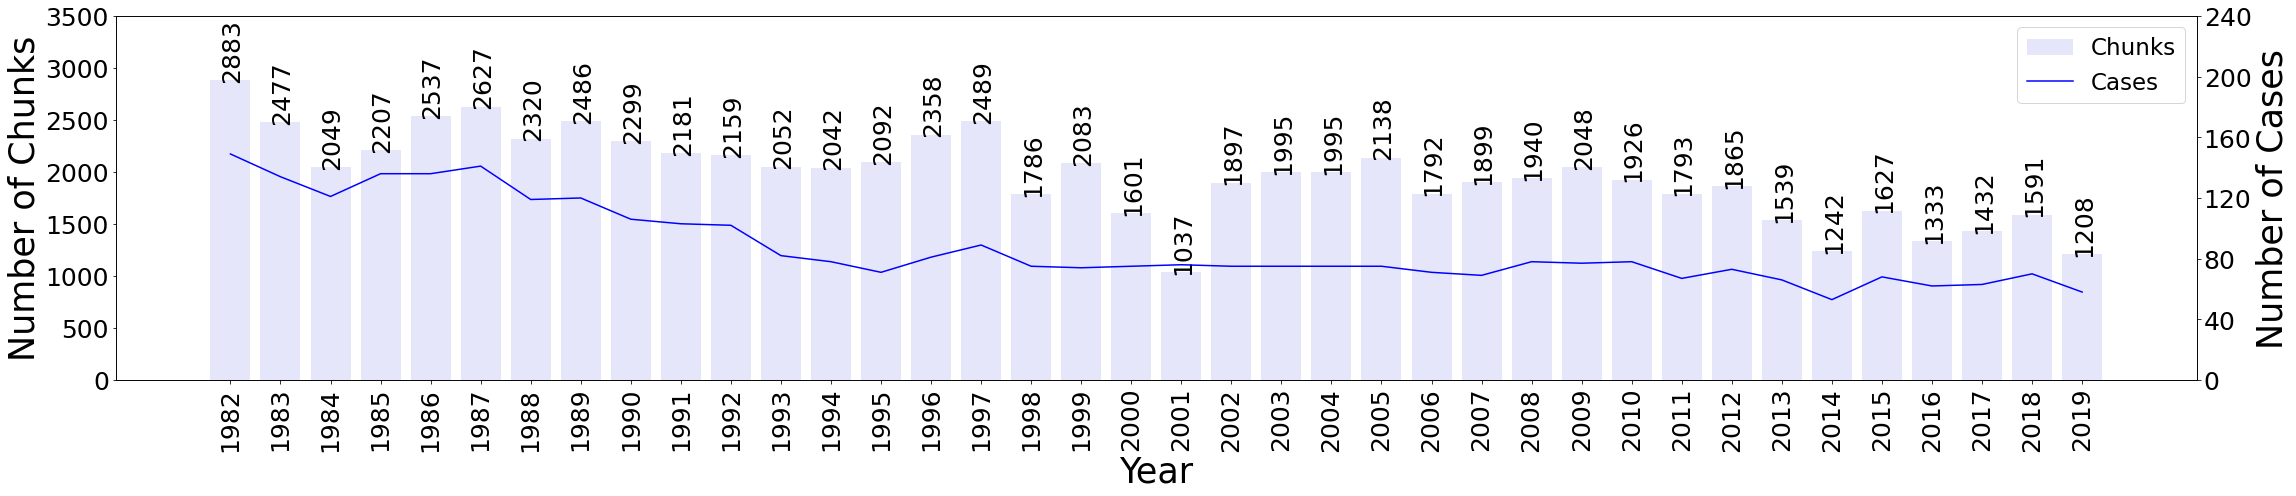

In [11]:
# We're using the df_raw, (before the justice filter)

years = np.arange(config['start_year'], config['end_year'], 1)

# Plot it 
fig, ax1 = plt.subplots(figsize=(32, 7))
color = 'tab:red'
# Left axis: Number of chunks 
ax1.set_xlabel('Year', fontsize=35)
ax1.set_ylabel('Number of Chunks', fontsize=35)
lns1 = ax1.bar(years, df_raw.groupby('case_year').count()['case_id'], color='lavender', label='Chunks')
_ = plt.xticks(years, rotation=90, fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0, 3500)
for x, y in zip(years, df_raw.groupby('case_year').count()['case_id']):
    plt.text(x-0.2, y+30, y, fontsize=25, rotation=90, color='black')

#Right axis: Number of cases 
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Cases',  fontsize=35)
lns2 = ax2.plot(years, number_of_cases, color='blue',  label='Cases')
ax2.set_yticks(np.arange(0, 250, 40), fontsize=35)
plt.yticks(fontsize=25)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes, fontsize=23)
plt.tight_layout()
plt.savefig("figs/fig1-num-chunks.pdf")
plt.show();

### Figure 2: Participation of Women in Oral Argument Exchanges

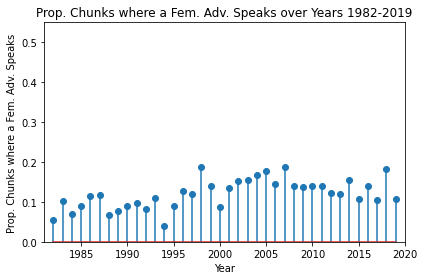

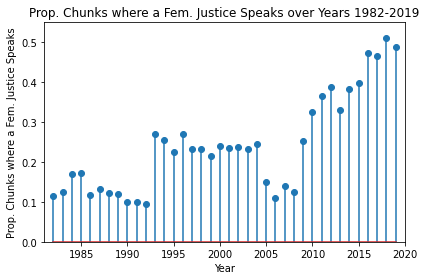

In [12]:
# This uses the df (after the justice filter since we have those justices coded for female/male)

years = [k for k in range(config['start_year'],config['end_year'],1)]

prop_fem_adv = []
prop_fem_just = []
prop_fem_advjust = []
prop_unknown = []
prop_fem_adv = []
prop_fem_just = []
prop_fem_advjust = []
prop_unknown = []

for y in years: 
    total_chunks = len(df[df['case_year']==y])
    fem_adv = len(df[(df['case_year']==y) & (df['advocate_gender']=='F')])
    fem_just = len(df[(df['case_year']==y) & (df['justice_gender']=='F')])
    fem_advjust = len(df[(df['case_year']==y) & ((df['advocate_gender']=='F') | (df['justice_gender']=='F'))])
    prop_fem_adv.append(fem_adv/total_chunks)
    prop_fem_just.append(fem_just/total_chunks)
    prop_fem_advjust.append(fem_advjust/total_chunks)
    prop_unknown.append((total_chunks - fem_adv-len(df[(df['case_year']==y) & (df['advocate_gender']=='M')]))/total_chunks)

plt.stem(years, prop_fem_adv)
plt.xlabel("Year")
plt.ylim(0,0.55)
plt.xlim(config['start_year']-1,config['end_year'])
plt.ylabel("Prop. Chunks where a Fem. Adv. Speaks")
plt.title("Prop. Chunks where a Fem. Adv. Speaks over Years 1982-2019")
plt.tight_layout()
plt.savefig("figs/fig2a-fem-advocate.pdf")
plt.show(); 

plt.stem(years, prop_fem_just)
plt.xlabel("Year")
plt.ylim(0,0.55)
plt.xlim(config['start_year']-1,config['end_year'])
plt.ylabel("Prop. Chunks where a Fem. Justice Speaks")
plt.title("Prop. Chunks where a Fem. Justice Speaks over Years 1982-2019")
plt.tight_layout()
plt.savefig("figs/fig2b-fem-justice.pdf")
plt.show(); 

### Figure 3: Interruption Rate Over Time.

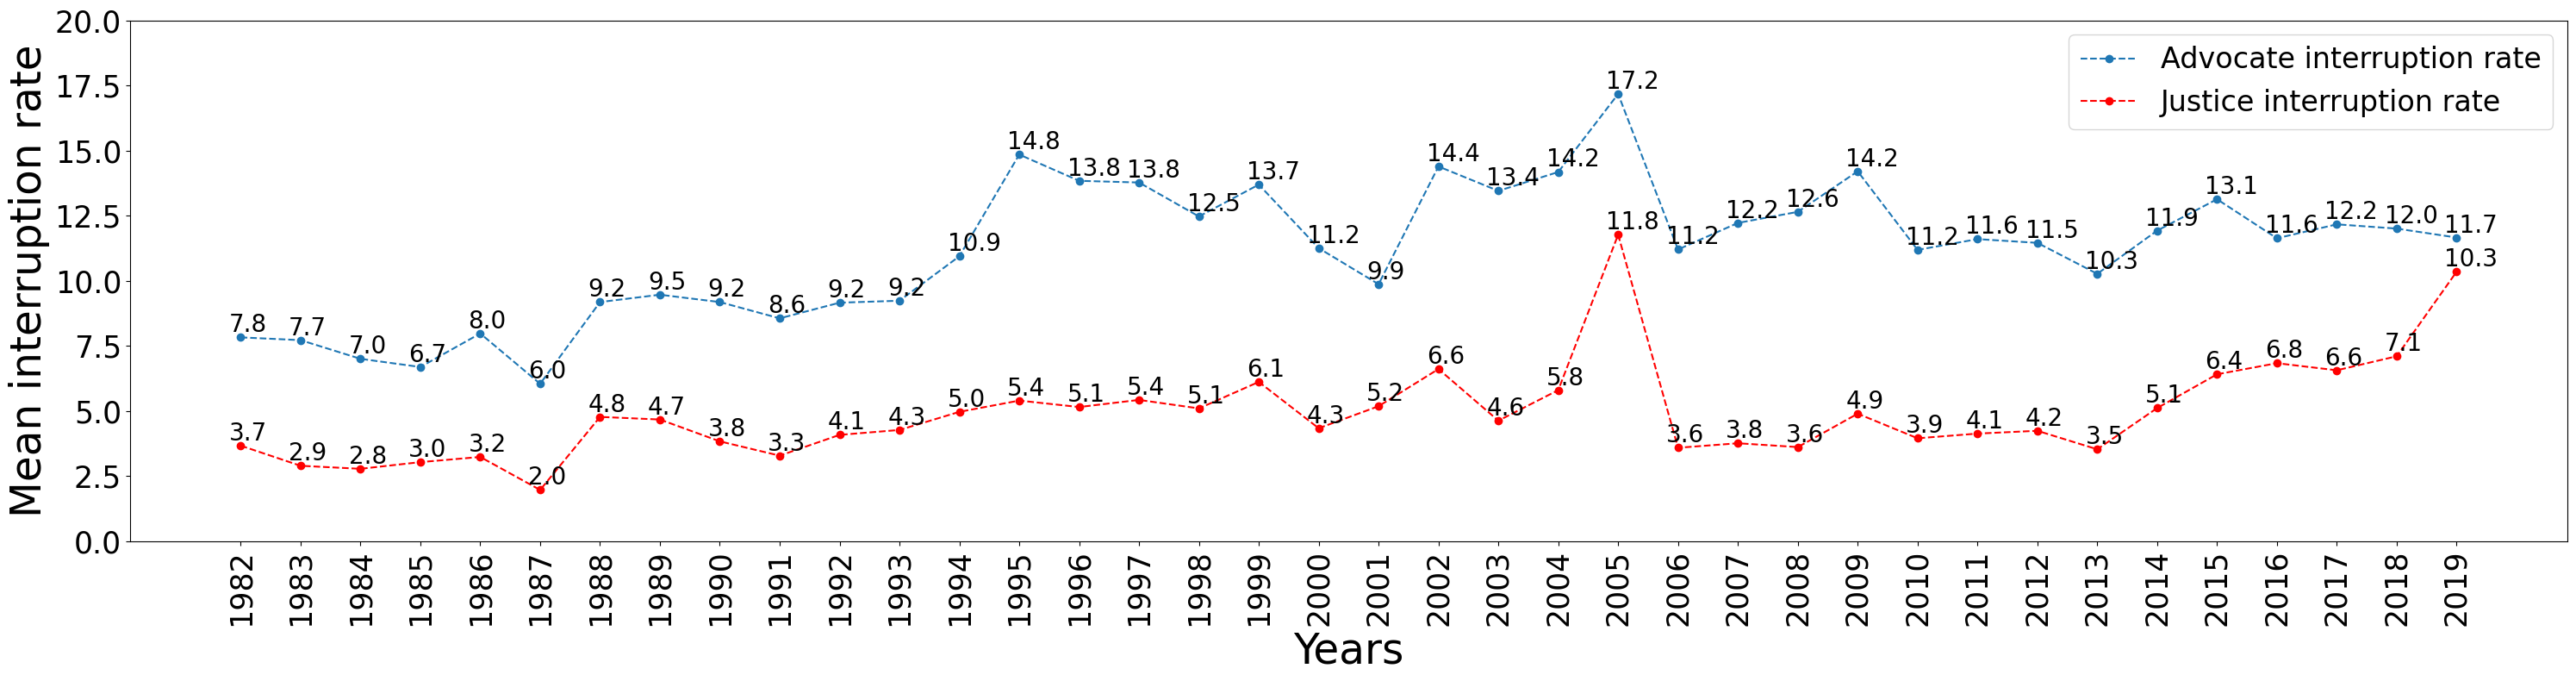

In [13]:
sns.reset_orig()
years = np.arange(config['start_year'], config['end_year'])

mean_adv_interruption_rate_over_years = []
for year in years:
    df_year = df[df.case_year==year]
    mean_adv_interruption_rate_over_years.append(df_year['adv_interruption_rate'].mean())
    
mean_justice_interruption_rate_over_years = []
for year in years:
    df_year = df[df.case_year==year]
    mean_justice_interruption_rate_over_years.append(df_year['justice_interruption_rate'].mean())
    
plt.figure(figsize=(30,8))
plt.plot(mean_adv_interruption_rate_over_years, 'o--', label='Advocate interruption rate')
plt.plot(mean_justice_interruption_rate_over_years, 'o--', color='red', label='Justice interruption rate')
plt.xticks(ticks=np.arange(len(years)), labels=years, fontsize=25, rotation=90)
for x, y in zip(np.arange(len(years)), mean_adv_interruption_rate_over_years):
    plt.text(x-0.2, y+0.2, np.round(y, 1), fontsize=20)
    

for x, y in zip(np.arange(len(years)), mean_justice_interruption_rate_over_years):
    plt.text(x-0.2, y+0.2, np.round(y, 1), fontsize=20)
    
plt.ylim(0, 20)
plt.yticks(fontsize=25)
plt.ylabel('Mean interruption rate', fontsize=35) #advocate utts
plt.xlabel('Years',fontsize=35)
plt.tight_layout()
plt.legend(loc='best', fontsize=24)
plt.savefig("figs/fig3-interruption-over-time.pdf")
plt.show()

### Aggregate by Justice

In [14]:
# Average interruption rate, E[Y]
df_ey_j = calc_ey(df)
df_ey_j

,justice_name,num_chunks,E[Y],justice_gender,justice_ideology
0,Anthony M. Kennedy,5383,12.269176,M,conservative
1,Antonin Scalia,11031,13.065834,M,conservative
2,Byron R. White,4764,10.279107,M,conservative
3,David H. Souter,3633,12.756122,M,liberal
4,Elena Kagan,1456,8.982103,F,liberal
5,John G. Roberts Jr.,2996,9.711165,M,conservative
6,John Paul Stevens,7041,10.474946,M,liberal
7,Ruth Bader Ginsburg,5338,9.224676,F,liberal
8,Samuel A. Alito Jr.,1807,8.673386,M,conservative
9,Sandra Day O'Connor,4847,10.145891,F,conservative


In [15]:
df_theta_gender_j = calc_theta_gender(df)
df_theta_gender_j

,justice_name,theta,total_num_chunks,justice_gender,justice_ideology
0,Anthony M. Kennedy,2.003134,5383,M,conservative
1,Antonin Scalia,1.651634,11031,M,conservative
2,Byron R. White,0.796183,4764,M,conservative
3,David H. Souter,1.497804,3633,M,liberal
4,Elena Kagan,-1.040374,1456,F,liberal
5,John G. Roberts Jr.,2.108876,2996,M,conservative
6,John Paul Stevens,0.582342,7041,M,liberal
7,Ruth Bader Ginsburg,1.156644,5338,F,liberal
8,Samuel A. Alito Jr.,1.066907,1807,M,conservative
9,Sandra Day O'Connor,2.182784,4847,F,conservative


In [16]:
df_theta_ideology_j = calc_theta_ideology(df)
df_theta_ideology_j

,justice_name,theta,total_num_chunks,justice_gender,justice_ideology
0,Anthony M. Kennedy,-0.717065,5383,M,conservative
1,Antonin Scalia,0.673478,11031,M,conservative
2,Byron R. White,-0.442708,4764,M,conservative
3,David H. Souter,-1.364395,3633,M,liberal
4,Elena Kagan,-0.176683,1456,F,liberal
5,John G. Roberts Jr.,0.635822,2996,M,conservative
6,John Paul Stevens,-0.639781,7041,M,liberal
7,Ruth Bader Ginsburg,0.181395,5338,F,liberal
8,Samuel A. Alito Jr.,0.485551,1807,M,conservative
9,Sandra Day O'Connor,-0.351964,4847,F,conservative


**Bootstrapping** 

Running the cell below may take 10-15 minutes. 

In [17]:
print("Number of bootstrap samples=", config["num_bootstrap_samples"])
bootstrap_std = get_bootstrap_std(df, num_bootstraps=config["num_bootstrap_samples"])
#Combine with the other dataframes 
np.testing.assert_array_equal(df_ey_j["justice_name"].to_numpy(), np.array(bootstrap_std['justices']))
df_ey_j["std"] = bootstrap_std['ey']
np.testing.assert_array_equal(df_theta_gender_j["justice_name"].to_numpy(), np.array(bootstrap_std['justices']))
df_theta_gender_j["theta_std"] = bootstrap_std['gender']
np.testing.assert_array_equal(df_theta_ideology_j["justice_name"].to_numpy(), np.array(bootstrap_std['justices']))
df_theta_ideology_j["theta_std"] = bootstrap_std['ideology']

Number of bootstrap samples= 1000


100%|███████████████████████████████████████| 1000/1000 [32:31<00:00,  1.95s/it]


### Table 3: Effects on advocate interruption rate, aggregated by justice gender

In [18]:
def aggregate_ci(df_local, std_column_name): 
    """
    Since we're taking the mean of the per-justice effects, this function first 
    finds the standard deviation of the aggregate effects via 
    
    $\frac{1}{n}\sqrt{\sum{_{j=1}^n}\sigma^2_j}$ 
    
    where $\sigma^2_j$ is the variance of the bootstrap distribution for justice $j$
    
    Then it uses the normal method to get the CI upper limit 
    """
    n = len(df_local) # number of justices.
    var = np.square(df_local[std_column_name].to_numpy())
    sqrt_sum_var = np.sqrt(np.sum(var)) 
    std_mean = 1/n*sqrt_sum_var#standard deviation of the mean 
    return 1.96*std_mean #normal method 1.96*standard deviation 

Mean across justices with CIs from per-justice bootstrapping chunks 

In [19]:
# All justices 
e1 = df_theta_gender_j["theta"].mean()
e1_ci = aggregate_ci(df_theta_gender_j, "theta_std") 
print("Justices:All, theta_gender ", np.round(e1, 2), "+-", np.round(e1_ci, 2))

# Male justices
m_subset = df_theta_gender_j[df_theta_gender_j['justice_gender']== "M"]
e2 = m_subset["theta"].mean()
e2_ci = aggregate_ci(m_subset, "theta_std")
print("Justices:M, theta_gender ", np.round(e2, 2), "+-", np.round(e2_ci, 2))

#Female justices 
f_subset = df_theta_gender_j[df_theta_gender_j['justice_gender']== "F"]
e3 = f_subset["theta"].mean()
e3_ci = aggregate_ci(f_subset, "theta_std")
print("Justices:F, theta_gender ", np.round(e3, 2), "+-", np.round(e3_ci, 2))

Justices:All, theta_gender  0.89 +- 0.36
Justices:M, theta_gender  1.06 +- 0.43
Justices:F, theta_gender  0.43 +- 0.68


In [20]:
# All justices 
i1 = df_theta_ideology_j["theta"].mean()
i1_ci = aggregate_ci(df_theta_ideology_j, "theta_std") 
print("Justices:All, theta_ideology ", np.round(i1, 2), "+-", np.round(i1_ci, 2))

# Male justices 
m_subset = df_theta_ideology_j[df_theta_ideology_j['justice_gender']== "M"]
i2 = m_subset["theta"].mean()
i2_ci = aggregate_ci(m_subset, "theta_std")
print("Justices:M, theta_ideology ", np.round(i2, 2), "+-", np.round(i2_ci, 2))

# Female justices 
f_subset = df_theta_ideology_j[df_theta_ideology_j['justice_gender']== "F"]
i3 = f_subset["theta"].mean()
i3_ci = aggregate_ci(f_subset, "theta_std")
print("Justices:F, theta_ideology ", np.round(i3, 2), "+-", np.round(i3_ci, 2))

Justices:All, theta_ideology  -0.25 +- 0.23
Justices:M, theta_ideology  -0.2 +- 0.27
Justices:F, theta_ideology  -0.39 +- 0.46


In [21]:
def ratio(e, i): 
    return np.abs(e/i)

In [22]:
print("Justices:All, ratio ", np.round(ratio(e1, i1), 2))
print("Justices:M, ratio ", np.round(ratio(e2, i2), 2))
print("Justices:F, ratio ", np.round(ratio(e3, i3), 2))

Justices:All, ratio  3.59
Justices:M, ratio  5.34
Justices:F, ratio  1.12


### Figure 4: Plot of Justice Interruption Rates, Effect of Gender, and Effect of Ideological Alignment

In [23]:
# Justice order should be ordered by theta gender from smallest to largest 
def reorganize(df, col, order):
    df = df.reindex(df[col].map(dict(zip(list(order), range(len(list(order)))))).sort_values().index)
    return df

order_justices_to_plot = df_theta_gender_j.sort_values(by='theta', ascending=False)['justice_name']
num_justices = len(order_justices_to_plot)
df_gender_ordered = reorganize(df_theta_gender_j, 'justice_name', order_justices_to_plot).reset_index(drop=True)
df_ideology_ordered = reorganize(df_theta_ideology_j, 'justice_name', order_justices_to_plot).reset_index(drop=True)
df_y_ordered = reorganize(df_ey_j, 'justice_name', order_justices_to_plot).reset_index(drop=True)

# Double-check the names are in the same order and same number of chunks
np.testing.assert_array_equal(df_gender_ordered['justice_name'].to_numpy(), 
                              df_ideology_ordered['justice_name'].to_numpy(),
                              df_y_ordered['justice_name'].to_numpy())
np.testing.assert_array_equal(df_gender_ordered['total_num_chunks'].to_numpy(), 
                              df_ideology_ordered['total_num_chunks'].to_numpy())

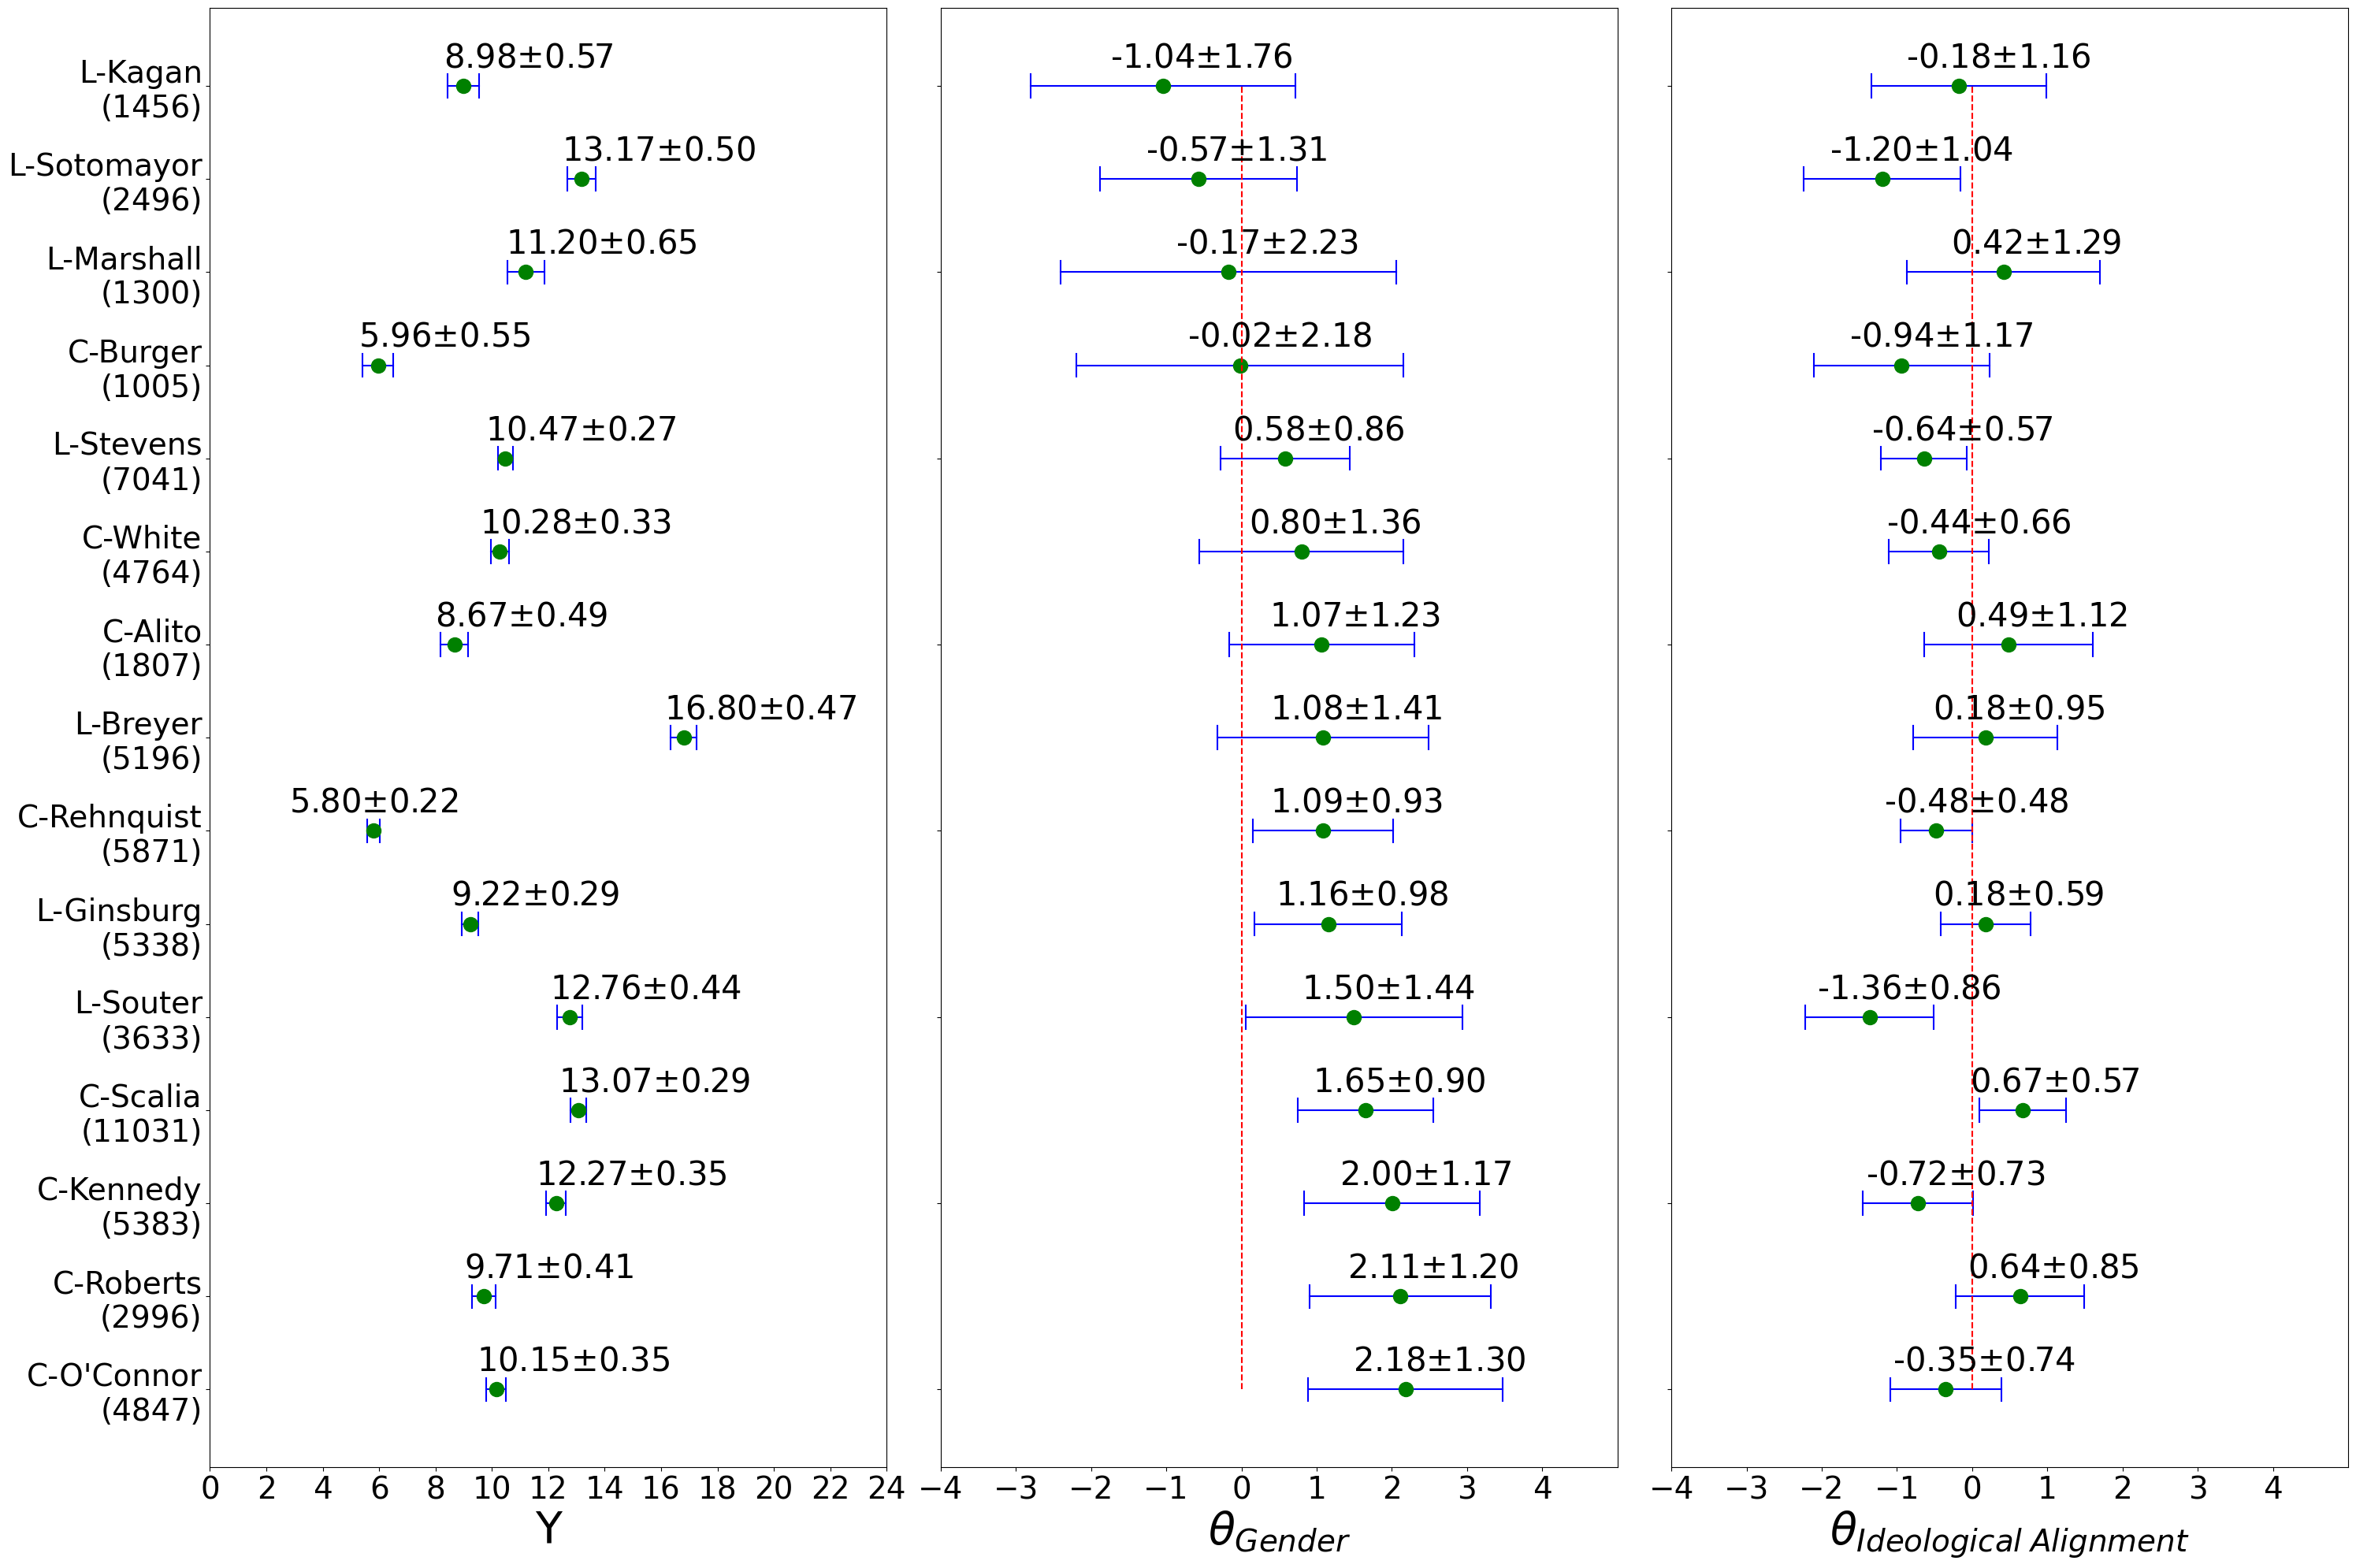

In [24]:
# Set-up figures 
plt.clf()
plt.close()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20))
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

# y-ticks: Liberal or conservative, Justice name and then number of chunks 
y1 = [str(x[0].upper()) for x in df_gender_ordered['justice_ideology']] # Upper case e.g., 'C' or 'L' for conservative or liberal 
y2 = [parse_last_name(x) for x in df_gender_ordered['justice_name'].to_list()] 
y3 = [str(x) for x in df_gender_ordered['total_num_chunks'].to_list()]

yticks = [y11+'-'+y22+'\n('+y33+')' for y11, y22, y33 in zip(y1, y2, y3)]

#######################
# Ax 1: Y (token-normalized interruption rate)
_ = ax1.set_yticks(np.arange(num_justices), yticks, rotation=0, fontsize=30)

ax1.set_xlim(5, 23)
ax1.set_xticks(np.arange(0, 25, 2), fontsize=30)
ax1.set_xlabel('Y', fontsize=40) 

for i in range(num_justices):
    plot_confidence_interval(ax1, 
                             i,
                            df_y_ordered.iloc[i]['E[Y]'],
                            df_y_ordered.iloc[i]['std'],
                            color='blue', horizontal_line_width=0.25, shift=True)
#######################
# Ax 2: Theta_Gender 
ax2.set_xlabel(r'$\theta_{Gender}$', fontsize=40)
for i in range(num_justices):
    plot_confidence_interval(ax2, 
                            i, 
                            df_gender_ordered.iloc[i]['theta'],
                            df_gender_ordered.iloc[i]['theta_std'])
    
ax2.plot([0]*num_justices, list(np.arange(num_justices)), '--', color='red')
ax2.set_xlim(-4, 5)
ax2.set_xticks(np.arange(-4, 5, 1), fontsize=100)

#######################
# Ax 2: Theta_Ideology
ax3.set_xlabel(r'$\theta_{Ideological\;Alignment}$', fontsize=40)
for i in range(num_justices):
    plot_confidence_interval(ax3, 
                            i, 
                            df_ideology_ordered.iloc[i]['theta'],
                            df_ideology_ordered.iloc[i]['theta_std'])

ax3.plot([0]*num_justices, list(np.arange(num_justices)), '--', color='red')
ax3.set_xlim(-4, 5)
ax3.set_xticks(np.arange(-4, 5, 1), fontsize=100)

#######################
for ax in fig.get_axes():
    ax.label_outer()
    ax.tick_params(axis='both', which='major', labelsize=28)
plt.tight_layout()
plt.savefig('figs/fig4-justice-effects.pdf')
plt.show();

### Table 2A in the appendix 
Print out what we plotted. 

In [25]:
df_gender_ordered = reorganize(df_theta_gender_j, 'justice_name', order_justices_to_plot).reset_index(drop=True)
df_ideology_ordered = reorganize(df_theta_ideology_j, 'justice_name', order_justices_to_plot).reset_index(drop=True)
df_y_ordered = reorganize(df_ey_j, 'justice_name', order_justices_to_plot).reset_index(drop=True)

In [26]:
df_new = df_y_ordered[['justice_name', 'E[Y]']].copy()
df_new['Y std'] = df_y_ordered['std'].to_numpy()
df_new['Gender Effect'] = df_gender_ordered['theta'].to_numpy()
df_new['Gender Effect (Std)'] = df_gender_ordered['theta_std'].to_numpy()
df_new['Ideological Alignment Effect'] = df_ideology_ordered['theta'].to_numpy()
df_new['Ideological Alignment Effect (Std)'] = df_ideology_ordered['theta_std'].to_numpy()
df_new['N (Chunks)'] = df_ideology_ordered['total_num_chunks'].to_numpy()

In [27]:
for i, row in df_new.iterrows(): 
    # We want each row to look like: 
    # \textit{Kagan} & 8.98 (0.29)  &  -1.04 (0.92) & 0.17 (0.62) & 1,456\\
    row_str = ""
    row_str += f"{row['justice_name']}"
    row_str += f"& {np.round(row['E[Y]'], 2)} ({np.round(row['Y std'], 2)})"
    row_str += f"& {np.round(row['Gender Effect'], 2)} ({np.round(row['Gender Effect (Std)'], 2)})"
    row_str += f"& {np.round(row['Ideological Alignment Effect'], 2)} ({np.round(row['Ideological Alignment Effect (Std)'], 2)})"
    row_str += f"& {row['N (Chunks)']} \\\\"
    print(row_str)

Sandra Day O'Connor& 10.15 (0.18)& 2.18 (0.66)& -0.35 (0.38)& 4847 \\
John G. Roberts Jr.& 9.71 (0.21)& 2.11 (0.61)& 0.64 (0.43)& 2996 \\
Anthony M. Kennedy& 12.27 (0.18)& 2.0 (0.6)& -0.72 (0.37)& 5383 \\
Antonin Scalia& 13.07 (0.15)& 1.65 (0.46)& 0.67 (0.29)& 11031 \\
David H. Souter& 12.76 (0.23)& 1.5 (0.73)& -1.36 (0.44)& 3633 \\
Ruth Bader Ginsburg& 9.22 (0.15)& 1.16 (0.5)& 0.18 (0.3)& 5338 \\
William H. Rehnquist& 5.8 (0.11)& 1.09 (0.47)& -0.48 (0.24)& 5871 \\
Stephen G. Breyer& 16.8 (0.24)& 1.08 (0.72)& 0.18 (0.49)& 5196 \\
Samuel A. Alito Jr.& 8.67 (0.25)& 1.07 (0.63)& 0.49 (0.57)& 1807 \\
Byron R. White& 10.28 (0.17)& 0.8 (0.69)& -0.44 (0.34)& 4764 \\
John Paul Stevens& 10.47 (0.14)& 0.58 (0.44)& -0.64 (0.29)& 7041 \\
Warren E. Burger& 5.96 (0.28)& -0.02 (1.11)& -0.94 (0.59)& 1005 \\
Thurgood Marshall& 11.2 (0.33)& -0.17 (1.14)& 0.42 (0.66)& 1300 \\
Sonia Sotomayor& 13.17 (0.25)& -0.57 (0.67)& -1.2 (0.53)& 2496 \\
Elena Kagan& 8.98 (0.29)& -1.04 (0.9)& -0.18 (0.59)& 1456 \\


### Save dataframe to reproduce Figure 5

In [59]:
df_figure5 = df_new[['justice_name', 'Gender Effect', 'Gender Effect (Std)']]

In [60]:
with open('../raw_data/justice2ideologyscores.json', 'r') as f:
    justice_ideology_scores = json.load(f)

In [61]:
df_figure5['justice_ideology_scores'] = df_figure5.apply(lambda x: justice_ideology_scores[parse_last_name(x['justice_name'])], axis=1)
df_figure5['justice_last_name'] = df_figure5.apply(lambda x: parse_last_name(x['justice_name']), axis=1)
df_figure5['Gender Effect (1.96*Std)'] = df_figure5.apply(lambda x: 1.96*x['Gender Effect (Std)'], axis=1)

In [62]:
df_figure5

,justice_name,Gender Effect,Gender Effect (Std),justice_ideology_scores,justice_last_name,Gender Effect (1.96*Std)
0,Sandra Day O'Connor,2.182784,0.660956,1.020,O'Connor,1.295473
1,John G. Roberts Jr.,2.108876,0.614413,0.910,Roberts,1.204249
2,Anthony M. Kennedy,2.003134,0.595863,0.682,Kennedy,1.167891
3,Antonin Scalia,1.651634,0.461315,2.510,Scalia,0.904177
4,David H. Souter,1.497804,0.733453,-0.770,Souter,1.437567
5,Ruth Bader Ginsburg,1.156644,0.499833,-1.740,Ginsburg,0.979672
6,William H. Rehnquist,1.086703,0.474648,2.970,Rehnquist,0.930311
7,Stephen G. Breyer,1.084790,0.717934,-1.260,Breyer,1.407151
8,Samuel A. Alito Jr.,1.066907,0.626591,1.850,Alito,1.228118
9,Byron R. White,0.796183,0.694465,0.440,White,1.361151


In [57]:
df_figure5.to_csv('./data/df_figure5.csv')